In [1]:
import random
import math

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,LabelBinarizer

import pymc as pm
import aesara.tensor as T
import arviz as az

In [2]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
az.style.use("arviz-darkgrid")

In [3]:
#Drop duplicates to ensure equal sample sizes during simulation
tox21_two_assays = pd.read_csv("../data/two-assay-example.csv").drop_duplicates(subset=['PROTOCOL_NAME', 'SAMPLE_NAME'])
organism = ['human' for i in range(tox21_two_assays.shape[0])] + ['animal' for i in range(tox21_two_assays.shape[0])]
new_protocol = [i + '-' + v for i,v in zip(pd.concat([tox21_two_assays['PROTOCOL_NAME'],tox21_two_assays['PROTOCOL_NAME']]),organism)]
simulated_two_assays = tox21_two_assays.copy()
four_assay_simulated = pd.concat([tox21_two_assays,simulated_two_assays])
four_assay_simulated['PROTOCOL_NAME'] = new_protocol
four_assay_simulated.insert(2,'ORGANISM',organism)
four_assay_simulated.reset_index(drop=True,inplace=True)

In [24]:
four_assay_simulated.head()

,PROTOCOL_NAME,CHANNEL_OUTCOME,ORGANISM,SAMPLE_NAME,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,tox21-ar-mda-kb2-luc-agonist-p3-human,inactive,human,Imipenem,11.938415,-1.104254,11.938415,0.052549,0.224452,299.352,...,1,0,0,0,0,0,0,0,2,0
1,tox21-ar-mda-kb2-luc-agonist-p3-human,inactive,human,Quinapril hydrochloride,13.260918,-1.036043,13.260918,0.000000,0.542299,474.985,...,0,0,0,0,0,0,0,0,0,0
2,tox21-ar-mda-kb2-luc-agonist-p3-human,inactive,human,Diphenoxylate hydrochloride,13.076853,-0.710688,13.076853,0.000000,0.369982,489.059,...,0,0,0,0,0,0,0,0,0,0
3,tox21-ar-mda-kb2-luc-agonist-p3-human,inactive,human,Eperisone hydrochloride,12.391306,0.000000,12.391306,0.000000,0.766044,295.854,...,0,0,0,0,0,0,0,0,0,0
4,tox21-ar-mda-kb2-luc-agonist-p3-human,inactive,human,Pranoprofen,11.024948,-0.820607,11.024948,0.513338,0.764395,255.273,...,0,0,0,0,0,0,0,0,0,0


In [4]:
vc = four_assay_simulated.groupby(["SAMPLE_NAME"]).agg({'PROTOCOL_NAME':'count'}).reset_index()

In [5]:
non_dup_samples = vc['SAMPLE_NAME'][vc['PROTOCOL_NAME']==4].values

In [6]:
len(non_dup_samples)

6453

In [7]:
RANDOM_SEED = 101
np.random.seed(RANDOM_SEED)

## Mathematical notation of the multi-level model

The dataset is composed of $c=1...M$ assays, within which $i=1...N_{c}$ compounds were tested for activity. The assay activity outcomes are binary and so we model the likelihood of compound $i$ being active in assay $c$ as a function of $j=1...p$ chemical descriptor features, $X$, and $k=1...q$ assay-level features $Z$.

The outcome data are treated as draws from a Bernoulli distribution with odd determined by a logit link to a multi-level linear predictor. The chemical-level regression coefficients $\beta_{j,c}$ reflect the effect of chemical descriptor $j$ on the odds of a compounds being active in assay $c$. The vector of chemical-level coefficients for each assay, $\vec{\beta_{c}}$, are modeled as draws from a multivariate normal distribution with expectation $\vec{\mu_{\beta_{c}}}$ and covariance matrix $\Sigma$. 

Further, the expected value of the chemical-level coefficients is modeled as a linear function of assay-level features. Specifically the assay-level regression coefficients, $\gamma_{k,j}$, reflect the effect of assay features $k$ on the regression coefficients for chemical descriptor $j$ across all $M$ assays. The $\gamma$ values themselves are modeled as being drawn from a normal distibution with mean zero and variance $\sigma^{2}_{\gamma}$; finally, the two chemical-level and assay-level linear predictors each have normal gaussian noise terms $\epsilon$ and $u$ respectively.

$$u \sim N(0,\sigma^{2}_{u})$$
$$\gamma  \sim N(0,\sigma^{2}_{\gamma})$$
$$\epsilon \sim N(0,\sigma^{2}_{\epsilon})$$
$$\mu_{\beta_{j,c}} = \gamma_{0,j} + \gamma_{1,j}z_{1,c} + ... + \gamma_{k,j}z_{q,c} + u_{j,c}$$
$$\vec{\beta_{c}} \sim MvNormal(\vec{\mu_{\beta_{c}}},\Sigma)$$
$$ \mathbb{E}[y_{i,c}|X,Z] = g^{-1}(\beta_{0,c} + \beta_{1,c}x_{1,i,c} +...+ \beta_{p,c}x_{j,i,c}+ \epsilon_{i,c})$$
$$ y_{i,c} \sim Bernoulli(\mathbb{E}[y_{i,c}|X,Z]) $$

# One assay feature and one chemical descriptor

In [9]:
niter = 10
n_compounds = 500
n_mcmc_samples = 500

simulated_results = []
for rit in range(niter):
    # Sample compounds
    random_compounds = np.random.choice(non_dup_samples,n_compounds,replace=False)
    test_data = four_assay_simulated[four_assay_simulated['SAMPLE_NAME'].isin(random_compounds)]

    test_data.loc[test_data["CHANNEL_OUTCOME"] == 1, "CHANNEL_OUTCOME"] = 'active antagonist'
    test_data.loc[test_data["CHANNEL_OUTCOME"] == 0, "CHANNEL_OUTCOME"] = 'inactive'

    assay_info = test_data.loc[:,('PROTOCOL_NAME','ORGANISM')].drop_duplicates()
    assay_info.insert(0,'Intercept',1)
    assay_info.PROTOCOL_NAME = pd.factorize(assay_info.PROTOCOL_NAME)[0]
    assay_info.ORGANISM = pd.factorize(assay_info.ORGANISM)[0]

    protocol_idx = pd.factorize(test_data['PROTOCOL_NAME'])#[0]
    organism_idx = pd.factorize(test_data['ORGANISM'])

    scaler = StandardScaler()
    X1 = scaler.fit_transform(test_data[['BCUT2D_CHGHI']])
    X = np.insert(X1,0,np.ones(len(X1)),axis=1)

    # Simulate activities based on hierarchichal random effects
    n_features = 1
    sig_beta = [0.5,0.5] #np.random.exponential(1,2)

    #Average intercept and average slope -- hard coded, no intercept slope covariance
    
    gamma = np.array([[-1, 1], [2, 2]]) + np.random.multivariate_normal([0,0],np.diag([0.1,0.1]),2)
    beta_corr = stats.random_correlation.rvs((1,1))
    sd_chol = np.linalg.multi_dot([np.diag(sig_beta),beta_corr,np.diag(sig_beta)])

    epsilon = np.random.multivariate_normal([0,0],np.diag([0.1,0.1]),assay_info.shape[0])
    mu_prot = np.matmul(assay_info.loc[:,('Intercept','ORGANISM')], gamma) + epsilon
    beta_prot = stats.matrix_normal.rvs(mu_prot,rowcov=np.identity(mu_prot.shape[0]),colcov=sd_chol)

    theta_sim = np.sum(X*beta_prot[protocol_idx[0]],axis=1)
    prob = 1.0 / (1.0 + np.exp(-theta_sim))
    Y = np.random.binomial(1,prob,len(prob))
    
    #sim_data = pd.DataFrame(np.insert(X,0,Y[0],axis=1))
    #sim_data.columns = ["Outcome","Intercept","BCUT2D_CHGHI"]
    #sim_data['PROTOCOL'] = protocol_idx[0]
    #sim_data['ORGANISM'] = organism_idx[0]

    coords_simulated = {
        'obs_id': np.arange(X.shape[0]),
        'protocol':protocol_idx[1],
        'params':['beta_{0}'.format(i) for i in range(X.shape[1])]
    }
    
    #Compile and run PyMC model
    with pm.Model(coords=coords_simulated) as assay_level_model:
        prot_mod_idx = pm.Data("protocol_idx", list(protocol_idx[0]),dims='obs_id',mutable=False)
        org_mod_idx = pm.Data("organism_idx", assay_info["ORGANISM"], dims="protocol",mutable=False)

        # prior stddev in intercepts & slopes (variation across protocol):
        sd_dist = pm.Exponential.dist(1.0)

        # get back standard deviations and rho:
        chol, corr, stds = pm.LKJCholeskyCov("chol", n=X.shape[1], eta=2.0, sd_dist=sd_dist, compute_corr=True)

        #hyperpriors and priors for average betas:
        beta_list = []
        for i in range(X.shape[1]):
            gbeta = pm.Normal("g_beta_{0}".format(i), mu=0.0, sigma=10.0, shape=2)
            mu_gbeta = gbeta[0] + gbeta[1] * org_mod_idx
            sigma_beta = pm.Exponential('sigma_beta_{0}'.format(i),1.0)
            beta_list.append(pm.Normal('beta_{0}'.format(i), mu=mu_gbeta,sigma=sigma_beta,dims="protocol"))

        #population of varying protocol effects:

        beta_protocol = pm.MvNormal("beta_protocol", mu=T.stack(beta_list, axis=1), chol=chol,dims=('protocol', 'params'))

        #Expected value per protocol:
        theta =  beta_protocol[prot_mod_idx,0] * X[:,0]
        for i in range(1,X.shape[1]):
            theta += beta_protocol[prot_mod_idx,i] * X[:,i]

        p = 1.0 / (1.0 + T.exp(-theta ))
        likelihood = pm.Bernoulli('likelihood', p, observed=Y,dims="obs_id")
        
        tr_assay = pm.sample(n_mcmc_samples, tune=1000, init="adapt_diag",chains=4)

        gamma_est = pd.concat([az.summary(tr_assay,'g_beta_{0}'.format(i), kind="stats") for i in range(2)])
        mu_prot_est = pd.concat([az.summary(tr_assay,'beta_{0}'.format(i), kind="stats") for i in range(2)])
        beta_prot_est = az.summary(tr_assay,"beta_protocol", kind="stats")

        gamma_est['simulated_value'] = np.transpose(gamma).reshape(-1)
        mu_prot_est['simulated_value'] = mu_prot.melt().drop('variable',axis=1).value.tolist()
        beta_prot_est['simulated_value'] = beta_prot.reshape(-1)
        
        res = {
            'X' : X,
            'Y' : Y,
            'gamma' : gamma_est,
            'mu_prot' : mu_prot_est,
            'beta_prot' : beta_prot_est
        }
        simulated_results.append(res)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol, g_beta_0, sigma_beta_0, beta_0, g_beta_1, sigma_beta_1, beta_1, beta_protocol]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 358 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 114 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6215, but should be close to 0.8. Try to increase the number of tuning steps.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol, g_beta_0, sigma_beta_0, beta_0, g_beta_1, sigma_beta_1, beta_1, beta_protocol]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 357 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol, g_beta_0, sigma_beta_0, beta_0, g_beta_1, sigma_beta_1, beta_1, beta_protocol]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 379 seconds.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5716, but should be close to 0.8. Try to increase the number of tuning steps.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.698, but should be close to 0.8. Try to increase the number of tuning steps.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6198, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol, g_beta_0, sigma_b

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 342 seconds.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6603, but should be close to 0.8. Try to increase the number of tuning steps.
There were 107 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6383, but should be close to 0.8. Try to increase the number of tuning steps.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol, g_beta_0, sigma_beta_0, beta_0, g_beta_1, sigma_beta_1, beta_1, beta_protocol]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2322 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 156 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5446, but should be close to 0.8. Try to increase the number of tuning steps.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5462, but should be close to 0.8. Try to increase the number of tuning steps.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol, g_beta_0, sigma_beta_0, beta_0, g_beta_1, sigma_beta_1, beta_1, beta_protocol]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 285 seconds.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6755, but should be close to 0.8. Try to increase the number of tuning steps.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol, g_beta_0, sigma_beta_0, beta_0, g_beta_1, sigma_beta_1, beta_1, beta_protocol]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 350 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6085, but should be close to 0.8. Try to increase the number of tuning steps.
There were 410 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1274, but should be close to 0.8. Try to increase the number of tuning steps.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6283, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol, g_beta_0, sigm

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 371 seconds.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7204, but should be close to 0.8. Try to increase the number of tuning steps.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol, g_beta_0, sigma_beta_0, beta_0, g_beta_1, sigma_beta_1, beta_1, beta_protocol]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 339 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol, g_beta_0, sigma_beta_0, beta_0, g_beta_1, sigma_beta_1, beta_1, beta_protocol]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 342 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.


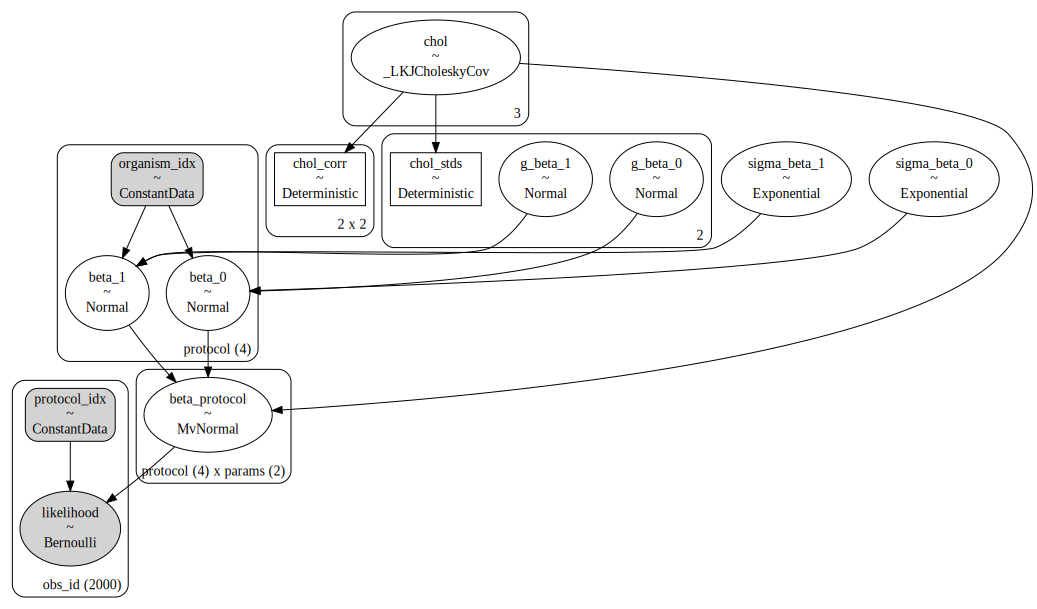

In [25]:
pm.model_to_graphviz(assay_level_model)

## Plot results

To assess the whether we have our model straight we plot the estimated parameters from the model against the corresponding values used in the simulation. The estimated values are very well correlated with their simulated values, suggesting that the model is working effectively. Fruther, we can see that the chemical-level coefficients ($\beta$) are estimates with less error than the assay-level coefficients ($\gamma$). This is intuitive because outcome data are conditionally independent of the assay-level data given a particular value for the chemical level coefficient; there are effectively more degrees of freedom for the assay-level coefficients. This intuition is further confirmed by noting that the the $mu_{\beta}$ estimates have a standard error intermediate between the $\beta$ and $\gamma$ estimates.

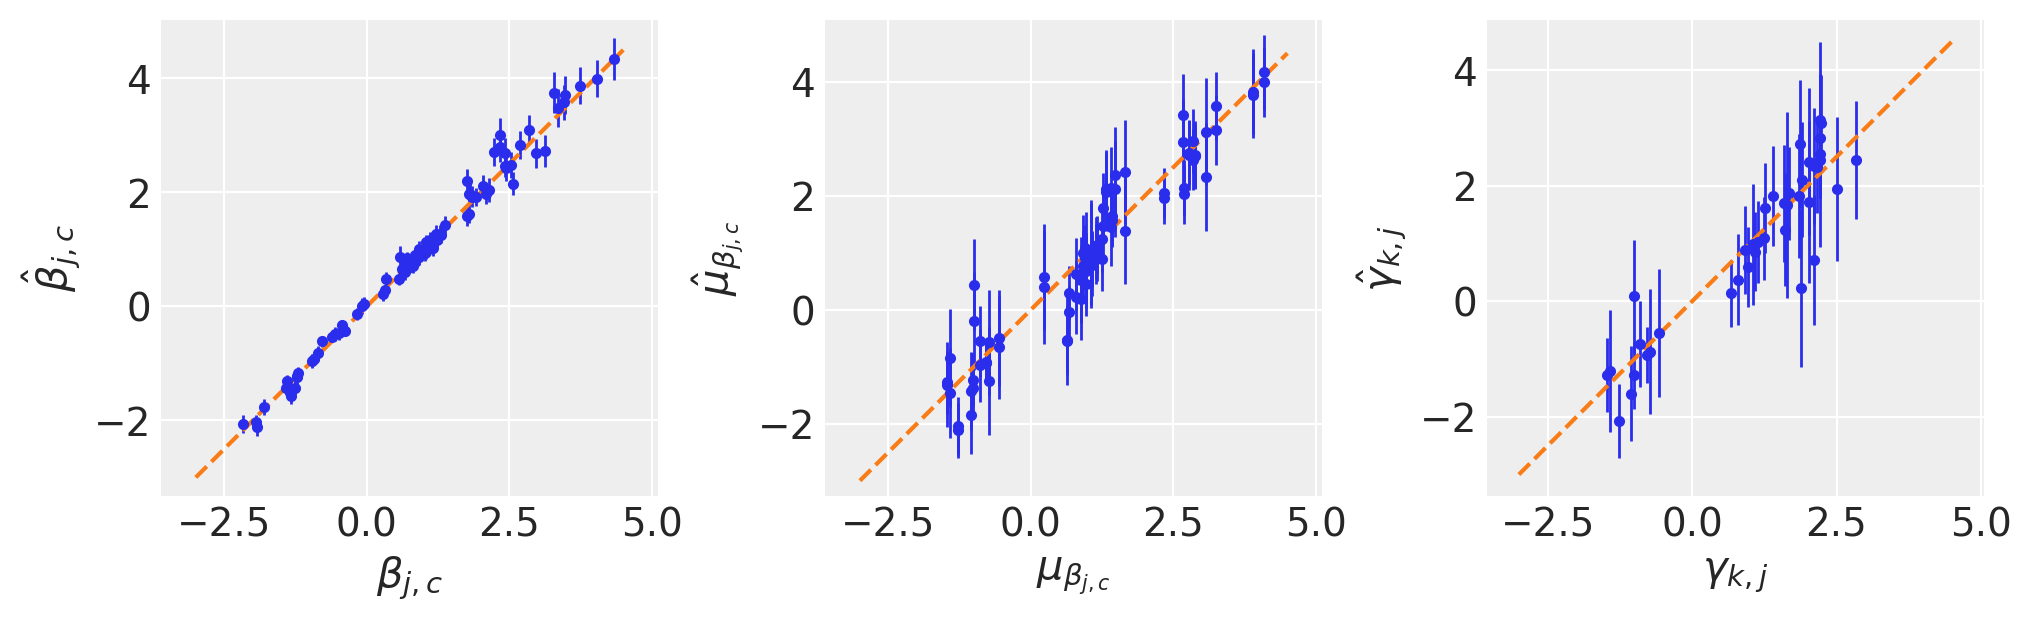

In [29]:
def abline(ax,slope, intercept):
    x_vals = np.array([-3,4.5])#np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--')

f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(10, 3))

#Estimated chemical-level (beta) coefficients for each protocol
beta_prot_est = pd.concat([i['beta_prot'] for i in simulated_results]).reset_index(drop=True)

ax1.errorbar(beta_prot_est['simulated_value'],beta_prot_est['mean'],beta_prot_est['sd'],fmt='o',lw=1,ms=3)
ax1.set_ylabel(r'$\hat{\beta}_{j,c}}$')
ax1.set_xlabel(r'$\beta_{j,c}$')
ax1.axis('equal')
abline(ax1, 1, 0) 


#Estimated expected coefficients
mu_prot_est = pd.concat([i['mu_prot'] for i in simulated_results]).reset_index(drop=True)

ax2.errorbar(mu_prot_est['simulated_value'],mu_prot_est['mean'],mu_prot_est['sd'],fmt='o',lw=1,ms=3)
ax2.set_ylabel(r'$\hat{\mu}_{\beta_{j,c}}$')
ax2.set_xlabel(r'$\mu_{\beta_{j,c}}$')
ax2.axis('equal')
abline(ax2, 1, 0) 

#Estimated assay-level (gamma) coefficients for each chemical-level (beta) coefficient
gamma_est = pd.concat([i['gamma'] for i in simulated_results]).reset_index(drop=True)

ax3.errorbar(gamma_est['simulated_value'],gamma_est['mean'].values,gamma_est['sd'],fmt='o',lw=1,ms=3)
ax3.set_ylabel(r'$\hat{\gamma}_{k,j}}$')
ax3.set_xlabel(r'$\gamma_{k,j}$')
ax3.axis('equal')
abline(ax3, 1, 0) 

plt.show()